In [2]:
# Import the libraries
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# Technical indicator library
import talib as ta

import datetime

from itertools import chain, combinations, product


import threading
import math


In [3]:

Df = pd.read_csv("./WIN$N_M15.csv",delimiter=",",decimal=".",dtype = {'Open': np.double, 'High': np.double, 'Low': np.double, 'Close': np.double})

Df = Df.dropna()
Df['Time'] = pd.to_datetime(Df['Time'],dayfirst=True)
start = datetime.datetime.now()


# we need to rename the columns since the SA lib uses a diferent name
Df.rename(columns={'Time': 'time', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
rates = Df.to_dict("records")
# let's change back the column's name
Df.rename(columns={'time': 'Time', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
Df['Time'] = pd.to_datetime(Df['Time'],dayfirst=True)



Df = Df.dropna()
# Prediction horizon (candles)
pred_horizon = 2

# Create a column 'Fut_Ret' with the calculation of returns
Df['Ret'] = (Df['Open'].shift(-pred_horizon)-Df['Open'])/Df['Open']

# # Create n columns and assign
# for i in range(1, n):
#     Df['return%i' % i] = Df['Ret'].shift(i)

Df = Df.dropna()

t = .8
split = int(t*len(Df))

# Create a column by name, 'Signal' and initialize with 0
Df['Signal']=0

# Assign a value of 1 to 'Signal' column for the quantile with highest returns
Df.loc[Df['Ret']>Df['Ret'][:split].quantile(q=0.66),'Signal']=1

# Assign a value of -1 to 'Signal' column for the quantile with lowest returns
Df.loc[Df['Ret']<Df['Ret'][:split].quantile(q=0.33),'Signal']=-1
# # # It is necessary for daytrade only. If you are using daily candles, please comment the lines below

# # Assign a value of 0 to 'Signal' column after 17h
Df.loc[(Df['Time'].dt.hour>16), 'Signal']=0

# Assign a value of 0 to 'Ret' column after 17h
Df.loc[(Df['Time'].dt.hour>16), 'Ret']=0

i_high = np.array(Df['High'].shift(1))
i_low = np.array(Df['Low'].shift(1))
i_close = np.array(Df['Close'].shift(1))
i_volume = np.array(Df['Volume'].shift(1))

indicators_groups = ['RSI', 'STOCH_k STOCH_D', 'MACD MACDSIGNAL', 'ADX', 'CCI', 'MFI', 'WILLR', 'TRIX']   

Df['RSI'] = ta.RSI(i_close)
Df['STOCH_k'], Df['STOCH_D'] = ta.STOCH(i_high, i_low, i_close)
Df['MACD'], Df['MACDSIGNAL'], _ = ta.MACD(i_close)
Df['ADX'] = ta.ADX(i_high, i_low, i_close)
Df['CCI'] = ta.CCI(i_high, i_low, i_close)
Df['MFI'] = ta.MFI(i_high, i_low, i_close, i_volume)
Df['WILLR'] = ta.WILLR(i_high, i_low, i_close)
Df['TRIX'] = ta.TRIX(i_close)

Df = Df.dropna()


indicators = set(list(' '.join(indicators_groups).split()))

def sa(_params):
    diff = list(indicators - set(_params))

    return Df.drop(diff, axis=1).copy()

Df

,Time,Open,High,Low,Close,Volume,Ret,Signal,RSI,STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,CCI,MFI,WILLR,TRIX
89,2014-02-17 13:15:00,48485.0,48570.0,48455.0,48550.0,2270,0.001031,0,37.052700,17.758985,16.953253,-27.783553,8.594372,14.007068,-181.430446,35.426562,-91.954023,0.019719
90,2014-02-17 13:30:00,48550.0,48555.0,48510.0,48530.0,730,-0.000206,0,41.907838,23.649187,19.206112,-34.377441,0.000010,15.370493,-127.816853,41.116284,-77.011494,0.018834
91,2014-02-17 13:45:00,48535.0,48550.0,48515.0,48540.0,529,-0.000515,0,40.863452,25.811117,22.406430,-40.747268,-8.149446,16.636530,-97.363328,44.742493,-81.609195,0.017901
92,2014-02-17 14:00:00,48540.0,48555.0,48490.0,48510.0,905,-0.001030,-1,41.646498,42.780814,30.747039,-44.475796,-15.414716,17.812136,-79.083847,42.435021,-79.310345,0.016942
93,2014-02-17 14:15:00,48510.0,48520.0,48485.0,48500.0,641,-0.001752,-1,39.937966,45.185185,37.925705,-49.283324,-22.188437,19.114009,-76.681614,47.051874,-86.206897,0.015953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77370,2022-09-20 11:30:00,112975.0,113020.0,112510.0,112790.0,610555,-0.001062,-1,58.756302,57.088480,43.093805,244.550199,321.804110,34.598051,14.047525,63.736266,-39.325843,0.041710
77371,2022-09-20 11:45:00,112785.0,112910.0,112615.0,112855.0,417011,0.000975,0,54.993227,65.143814,54.436136,228.073578,303.058004,33.264575,-17.107605,57.907672,-53.183521,0.041664
77372,2022-09-20 12:00:00,112855.0,113050.0,112655.0,112895.0,450579,0.000709,0,56.058090,64.589166,62.273820,217.750601,285.996523,32.026348,-3.633303,58.728479,-48.314607,0.041544
77373,2022-09-20 12:15:00,112895.0,113175.0,112815.0,112935.0,447571,0.001639,1,56.736464,57.595783,62.442921,210.372194,270.871657,31.205506,33.585859,60.355205,-43.629344,0.041366


In [4]:
def generate_indicators():
    s = list(indicators_groups)
    _result = list(chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1)))
    return list(map(lambda x: list(' '.join(x).split()), _result))
    
def CalculateMetrics(_returns, _y_pred, _dates, optimize=False, prediction_horizon=1, type_='percentual'):
    #Receive the dates, predictions and returns, apply a simple trading strategy (exit position after n candles, without tp and sl), and show the results and graph"""

    #--- get the returns if we follow the strategy (follow the prediction signals) - it is equivalent to buying or selling according to the signal, and keep the position for n candles. We can have multiple positions at the same time, without sl and tp
    strategy_returns=[_y_pred[i] * _returns[i] for i in range(0, len(_y_pred))]

    #--- get the cumulative return of our strategy - increasing position - juros composto
    strategy_accumulated_prod = 1
    for i in range(1, len(strategy_returns)):
        strategy_accumulated_prod *= (strategy_returns[i]+1)
    strategy_accumulated_prod -= 1

    #--- get the cumulative return of our strategy
    strategy_accumulated = copy.copy(strategy_returns)
    for i in range(1, len(strategy_accumulated)):
        strategy_accumulated[i] = strategy_accumulated[i-1] + strategy_returns[i]

    #--- get the cumulative return of the asset - where we buy only, at every candle, and keeps the position opened for n candles
    asset_accumulated = copy.copy(_returns)
    for i in range(1, len(asset_accumulated)):
        asset_accumulated[i] = asset_accumulated[i-1] + _returns[i]


    #--- get the cumulative loss of our strategy - draw down
    strategy_drawdown = copy.copy(strategy_returns)
    for i in range(1, len(strategy_drawdown)):
        strategy_drawdown[i] = (strategy_drawdown[i-1] + strategy_returns[i] if strategy_drawdown[i-1] + strategy_returns[i] < 0 else 0)

    drawdown_max = np.min(np.array(strategy_drawdown))
    drawdown_mean = np.mean(np.array(strategy_drawdown))
    total_return = strategy_accumulated[-1]
    total_days = len(list(set([date.strftime("%Y-%m-%d") for date in _dates])))
    total_months = total_days / 21
    monthly_return = (total_return/total_months if total_months>0 else 0)
    drawdown_max_by_monthly_return = (-drawdown_max/monthly_return if monthly_return != 0 else 0)
    drawdown_mean_by_monthly_return = (-drawdown_mean/monthly_return if monthly_return != 0 else 0)


    #--- calculating a few metrics

    if optimize:
        e = []
        for i,pred in enumerate(_y_pred):
            if _y_pred[max(0, i - prediction_horizon)] != pred: e.append(abs(pred))
        entries = np.sum(np.array(e))
    else:
        entries = np.sum(np.array([abs(pred) for pred in _y_pred]))
        entries_buy = int(np.sum(np.array([abs(pred) for pred in _y_pred if pred > 0])))
        entries_sell = int(np.sum(np.array([abs(pred) for pred in _y_pred if pred < 0])))
    total_return = strategy_accumulated[-1]
    if entries>0:
        return_per_entry = total_return / entries
    else:
        return_per_entry = 0

    poss = sum([1 for return_ in strategy_returns if return_ > 0])
    negs = sum([1 for return_ in strategy_returns if return_ < 0])
    success = (poss+1) / (poss + negs+2)

    poss_ = sum([return_ for return_ in strategy_returns if return_ > 0])
    negs_ = sum([return_ for return_ in strategy_returns if return_ < 0])
    profitFactor = -((poss_+0.000001)/(negs_+0.000001))
    return [round(total_return*100,4), entries, round(return_per_entry*100,4), round(success*100,2), round(profitFactor,2), total_days, round(total_months,4), round(monthly_return*100,4), round(drawdown_max*100,4), round(drawdown_mean*100,4), entries_buy, entries_sell]


def PreviousCalculateMetrics(returns,y_pred,dates,optimize=False,prediction_horizon=1,type_='percentual'):
    #Receive the dates, predictions and returns, apply a simple trading strategy (exit position after n candles, without tp and sl), and show the results and graph"""

    #--- get the returns if we follow the strategy (follow the prediction signals) - it is equivalent to buying or selling according to the signal, and keep the position for n candles. We can have multiple positions at the same time, without sl and tp
    strategy_returns=[y_pred[i]*returns[i] for i in range(0,len(y_pred))]

    #--- get the cumulative return of our strategy - increasing position - juros composto
    strategy_accumulated_prod = 1
    for i in range(1, len(strategy_returns)):
        strategy_accumulated_prod *= (strategy_returns[i]+1)
    strategy_accumulated_prod -= 1

    #--- get the cumulative return of our strategy
    strategy_accumulated = copy.copy(strategy_returns)
    for i in range(1, len(strategy_accumulated)):
        strategy_accumulated[i] = strategy_accumulated[i-1] + strategy_returns[i]

    #--- get the cumulative return of the asset - where we buy only, at every candle, and keeps the position opened for n candles
    asset_accumulated = copy.copy(returns)
    for i in range(1, len(asset_accumulated)):
        asset_accumulated[i] = asset_accumulated[i-1] + returns[i]


    #--- get the cumulative loss of our strategy - draw down
    strategy_drawdown = copy.copy(strategy_returns)
    for i in range(1, len(strategy_drawdown)):
        strategy_drawdown[i] = (strategy_drawdown[i-1] + strategy_returns[i] if strategy_drawdown[i-1] + strategy_returns[i] < 0 else 0)

    drawdown_max = np.min(np.array(strategy_drawdown))
    drawdown_mean = np.mean(np.array(strategy_drawdown))
    total_return = strategy_accumulated[-1]
    total_days = len(list(set([date.strftime("%Y-%m-%d") for date in dates])))
    total_months = total_days / 21
    monthly_return = (total_return/total_months if total_months>0 else 0)
    drawdown_max_by_monthly_return = (-drawdown_max/monthly_return if monthly_return != 0 else 0)
    drawdown_mean_by_monthly_return = (-drawdown_mean/monthly_return if monthly_return != 0 else 0)


    #--- calculating a few metrics

    if optimize:
        e = []
        for i,pred in enumerate(y_pred):
            if y_pred[max(0,i-prediction_horizon)] != pred: e.append(abs(pred))
        entries = np.sum(np.array(e))
    else:
        entries = np.sum(np.array([abs(pred) for pred in y_pred]))
        entries_buy = int(np.sum(np.array([abs(pred) for pred in y_pred if pred>0])))
        entries_sell = int(np.sum(np.array([abs(pred) for pred in y_pred if pred<0])))
    total_return = strategy_accumulated[-1]
    if entries>0:
        return_per_entry = total_return / entries
    else:
        return_per_entry = 0

    poss = sum([1 for return_ in strategy_returns if return_ > 0])
    negs = sum([1 for return_ in strategy_returns if return_ < 0])
    success = (poss+1) / (poss + negs+2)

    poss_ = sum([return_ for return_ in strategy_returns if return_ > 0])
    negs_ = sum([return_ for return_ in strategy_returns if return_ < 0])
    profitFactor = -((poss_+0.000001)/(negs_+0.000001))

    if type_ == 'percentual':
        print(
            "\n \tTotal return: ",round(total_return*100,4),"%",
            "\n \tEntries: ", entries,
            "\n \tReturn per entry: ", round(return_per_entry*100,4),"%",
            "\n \tSuccess: ", round(success*100,2),"%",
            "\n \tRatio: ", round(profitFactor,2),
            "\n \tTotal of days: ", total_days,
            "\n \tTotal of months: ", round(total_months,4),
            "\n \tMonthly return: ", round(monthly_return*100,4),"%",
            "\n \tMax drawdown: ", round(drawdown_max*100,4),"%",
            "\n \tMean drawdown: ", round(drawdown_mean*100,4),"%",
            "\n \tBuy signals", entries_buy,
            "\n \tSell signals", entries_sell,
        )
    else:
        print(
            "\n \tTotal return: ",round(total_return,4),
            "\n \tEntries: ", entries,
            "\n \tReturn per entry: ", round(return_per_entry,4),
            "\n \tSuccess: ", round(success*100,2),"%",
            "\n \tRatio: ", round(profitFactor,2),
            "\n \tTotal of days: ", total_days,
            "\n \tTotal of months: ", round(total_months,4),
            "\n \tMonthly return: ", round(monthly_return,4),
            "\n \tMax drawdown: ", round(drawdown_max,4),
            "\n \tMean drawdown: ", round(drawdown_mean,4),
            "\n \tBuy signals", entries_buy,
            "\n \tSell signals", entries_sell,
        )


def execute_test(indicators__, result__, count__, lock__, print_result = False):
    count = count__
    for params in indicators__:
        try:
            lock__.acquire()
            print(str(count + 1) + " starting " + ','.join(params))
            lock__.release()
            df = sa(params)

            X = df.drop(['Ret',"Time","Signal", 'Close', 'Signal', 'High',
                         'Low', 'Open', 'Volume', 'Ret'], axis=1)

            # Create a variable which contains all the 'Signal' values
            y = df['Signal']

            cls = QuadraticDiscriminantAnalysis()

            ss1 = StandardScaler()

            # Pass the scaled train data to the SVC classifier
            cls.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])

            # Pass the test data to the predict function and store the values into 'y_predict'
            y_predict = cls.predict(ss1.transform(X.iloc[split:]))

            # This is an alternative approach to generate the predictions.
            # It uses the same method used in the ML framework, generates predictions based on a list of probability
            # Please, uncomment the last line of this code block if you want to use it

            y_prob = cls.predict_proba(ss1.transform(X.iloc[split:]))

            # Initiate a column by name, 'Pred_Signal' and assign 0 to it
            df['Pred_Signal'] = 0

            # Save the predicted values for the train data
            # df.iloc[:split,df.columns.get_loc('Pred_Signal')] = pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())
            df.iloc[:split,df.columns.get_loc('Pred_Signal')] =cls.predict(ss1.transform(X.iloc[:split]))

            # Save the predicted values for the test data
            df.iloc[split:,df.columns.get_loc('Pred_Signal')] = y_predict

            df['Profit'] = df['Pred_Signal']*df['Ret']

            df["Test_Set"] = 0
            df.loc[split:,"Test_Set"] = 1
            # df.to_csv("output_pred.csv")

            df.to_csv("output_pred.csv")
            # Calculate strategy returns and store them in 'Ret1' column
            df['Ret1'] = df['Ret'] * df['Pred_Signal']

            # Strategy Metrics
            returns = list(df['Ret'][split:])
            y_pred = list(df['Pred_Signal'][split:])
            dates = list(df['Time'][split:])
            metrics_test = CalculateMetrics(returns,y_pred,dates,type_='percentual')

            # Strategy Metrics
            returns = list(df['Ret'][:split])
            y_pred = list(df['Pred_Signal'][:split])
            dates = list(df['Time'][:split])
            metrics_training = CalculateMetrics(returns, y_pred, dates, type_='percentual')

            ok = [','.join(params)] + metrics_training + metrics_test
            lock__.acquire()
            result__.append(ok)
            if print_result:
                # Strategy Metrics
                returns = list(df['Ret'][split:])
                y_pred = list(df['Pred_Signal'][split:])
                dates = list(df['Time'][split:])
                print("\nStrategy results %: ")
                PreviousCalculateMetrics(returns,y_pred,dates,type_='percentual')

                returns_absolute = list((df['Ret']*df['Open'])[split:])
                print("\nStrategy results: ")
                PreviousCalculateMetrics(returns_absolute,y_pred,dates,type_='points')

                df.set_index("Time", inplace=True)
                # Plot the strategy returns in the test period
                plt.figure(figsize=(10,10))
                # plt.plot(((df['Ret'][:split]+1).cumprod()-1),color='r',label='Mini-índice')
                # plt.plot(((df['Ret1'][:split]+1).cumprod()-1),color='g',label='Estratégia')
                plt.plot(((df['Ret'][:split]).cumsum()),color='r',label='Baseline')
                plt.plot(((df['Ret1'][:split]).cumsum()),color='g',label='estratégia')
                plt.plot((((df['Open'].shift(-1) - df['Open']) / df['Open'])[:split] + 1).cumprod() - 1, color='b', label='winfut')
                plt.legend()
                plt.xticks(rotation=-45)
                plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
                plt.show()


                # Plot the strategy returns in the test period
                plt.figure(figsize=(10,10))
                # plt.plot(((df['Ret'][split:]+1).cumprod()-1),color='r',label='Mini-índice')
                # plt.plot(((df['Ret1'][split:]+1).cumprod()-1),color='g',label='Estratégia')
                plt.plot(((df['Ret'][split:]).cumsum()),color='r',label='Baseline')
                plt.plot(((df['Ret1'][split:]).cumsum()),color='g',label='estratégia-teste')
                plt.plot((((df['Open'].shift(-1) - df['Open']) / df['Open'])[split:] + 1).cumprod() - 1, color='b', label='winfut')
                plt.legend()
                plt.xticks(rotation=-45)
                plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
                plt.show()
            lock__.release()
            count += 1
            lock__.acquire()
            print(str(count) + ' finishing ' + ','.join(params))
            lock__.release()
        except Exception as e:
            count += 1
            lock__.acquire()
            print(str(count) + 'ERROR ERROR ERROR ' + ','.join(params))
            print(e)
            lock__.release()



def runFullTest(params_, csv_name):
    lock = threading.Lock()
    results = []
    threads = [None] * 2
    slice_size = math.ceil(float(len(params_)) / float(len(threads)))

    for i in range(len(threads)):
        params = params_[(i * slice_size):((i + 1) * slice_size)]
        threads[i] = threading.Thread(target=execute_test, args=(params, results, i * slice_size, lock))
        threads[i].start()

    for i in range(len(threads)):
        threads[i].join()
    columns_training = ['Total return (training)', 'Entries (training)', 'Return per entry (training)', 'Success (training)', 'Ratio (training)', 'Total of days (training)', 'Total of months (training)', 'Monthly return (training)', 'Max drawdown (training)', 'Mean drawdown (training)', 'Buy signals (training)', 'Sell signals (training)']
    columns_test = ['Total return (test)', 'Entries (test)', 'Return per entry (test)', 'Success (test)', 'Ratio (test)', 'Total of days (test)', 'Total of months (test)', 'Monthly return (test)', 'Max drawdown (test)', 'Mean drawdown (test)', 'Buy signals (test)', 'Sell signals (test)']

    resultsDf = pd.DataFrame(results, columns=['indicators'] + columns_training + columns_test)
    resultsDf.to_csv(f'{csv_name}.csv', index=False)
    return resultsDf




In [5]:
indicators_combinations = generate_indicators()

runFullTest(indicators_combinations, 'indicators-test')

1 starting RSI
129 starting STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,MFI
1 finishing RSI
2 starting STOCH_k,STOCH_D
129 finishing STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,MFI
130 starting STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,WILLR
2 finishing STOCH_k,STOCH_D
3 starting MACD,MACDSIGNAL
130 finishing STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,WILLR
131 starting STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,TRIX
3 finishing MACD,MACDSIGNAL
4 starting ADX
4 finishing ADX
5 starting CCI
131 finishing STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,TRIX
132 starting STOCH_k,STOCH_D,MACD,MACDSIGNAL,CCI,MFI
5 finishing CCI
6 starting MFI
132 finishing STOCH_k,STOCH_D,MACD,MACDSIGNAL,CCI,MFI
133 starting STOCH_k,STOCH_D,MACD,MACDSIGNAL,CCI,WILLR
6 finishing MFI
7 starting WILLR
133 finishing STOCH_k,STOCH_D,MACD,MACDSIGNAL,CCI,WILLR
134 starting STOCH_k,STOCH_D,MACD,MACDSIGNAL,CCI,TRIX
7 finishing WILLR
8 starting TRIX
8 finishing TRIX
9 starting RSI,STOCH_k,STOCH_D
134 finishing STOCH_k,STOCH_D,MACD,MACDSIGNAL,CCI,TRIX
135 starting 

,indicators,Total return (training),Entries (training),Return per entry (training),Success (training),Ratio (training),Total of days (training),Total of months (training),Monthly return (training),Max drawdown (training),...,Return per entry (test),Success (test),Ratio (test),Total of days (test),Total of months (test),Monthly return (test),Max drawdown (test),Mean drawdown (test),Buy signals (test),Sell signals (test)
0,RSI,28.1596,474,0.0594,53.22,1.47,1710,81.4286,0.3458,-9.2192,...,0.0734,59.26,1.89,414,19.7143,0.3575,-2.0287,-0.1554,96,0
1,"STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,MFI",151.1028,6607,0.0229,51.84,1.14,1710,81.4286,1.8556,-35.5640,...,0.0015,50.50,1.01,414,19.7143,0.2761,-34.4744,-15.5787,2381,1157
2,"STOCH_k,STOCH_D",0.0000,0,0.0000,50.00,-1.00,1710,81.4286,0.0000,0.0000,...,0.0000,50.00,-1.00,414,19.7143,0.0000,-0.0000,0.0000,0,0
3,"STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,WILLR",208.8411,6382,0.0327,52.03,1.21,1710,81.4286,2.5647,-28.3920,...,0.0013,50.30,1.01,414,19.7143,0.2283,-23.1691,-12.1237,2484,1099
4,"MACD,MACDSIGNAL",151.1783,6100,0.0248,51.74,1.15,1710,81.4286,1.8566,-41.5622,...,0.0005,50.21,1.00,414,19.7143,0.0940,-18.4589,-8.5263,2370,1169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,"RSI,STOCH_k,STOCH_D,MACD,MACDSIGNAL,CCI,MFI,WI...",214.0711,7807,0.0274,52.78,1.17,1710,81.4286,2.6289,-24.0587,...,0.0046,50.13,1.04,414,19.7143,0.8039,-15.4579,-5.9071,1871,1604
251,"RSI,STOCH_k,STOCH_D,ADX,CCI,MFI,WILLR,TRIX",207.3954,9163,0.0226,53.01,1.16,1710,81.4286,2.5470,-32.4440,...,0.0034,50.71,1.03,414,19.7143,0.3332,-19.0035,-8.5242,1519,398
252,"RSI,MACD,MACDSIGNAL,ADX,CCI,MFI,WILLR,TRIX",251.0792,8473,0.0296,52.53,1.20,1710,81.4286,3.0834,-27.1024,...,0.0078,51.93,1.07,414,19.7143,1.4493,-18.1632,-5.8093,2080,1569
253,"STOCH_k,STOCH_D,MACD,MACDSIGNAL,ADX,CCI,MFI,WI...",228.9523,8715,0.0263,52.81,1.17,1710,81.4286,2.8117,-27.4419,...,0.0071,50.63,1.07,414,19.7143,1.3250,-18.4218,-8.8253,2144,1533


1 starting ADX,WILLR

Strategy results %: 

 	Total return:  2.4076 % 
 	Entries:  13 
 	Return per entry:  0.1852 % 
 	Success:  81.82 % 
 	Ratio:  298.32 
 	Total of days:  414 
 	Total of months:  19.7143 
 	Monthly return:  0.1221 % 
 	Max drawdown:  -0.0082 % 
 	Mean drawdown:  -0.0016 % 
 	Buy signals 13 
 	Sell signals 0

Strategy results: 

 	Total return:  2660.0 
 	Entries:  13 
 	Return per entry:  204.6154 
 	Success:  81.82 % 
 	Ratio:  267.0 
 	Total of days:  414 
 	Total of months:  19.7143 
 	Monthly return:  134.9275 
 	Max drawdown:  -10.0 
 	Mean drawdown:  -1.9147 
 	Buy signals 13 
 	Sell signals 0


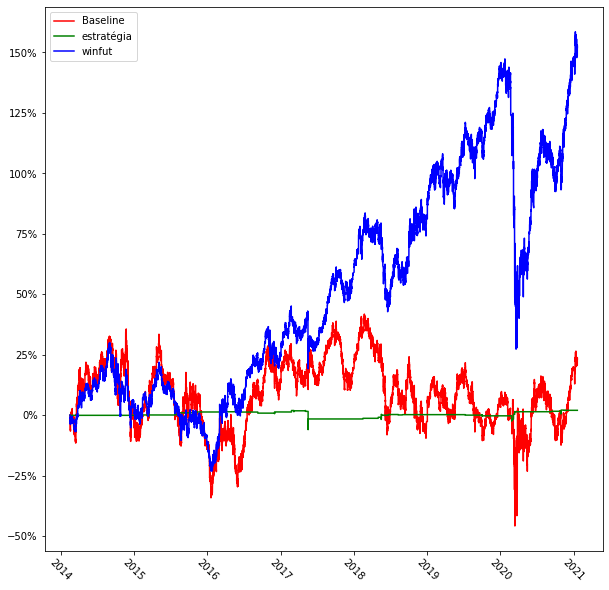

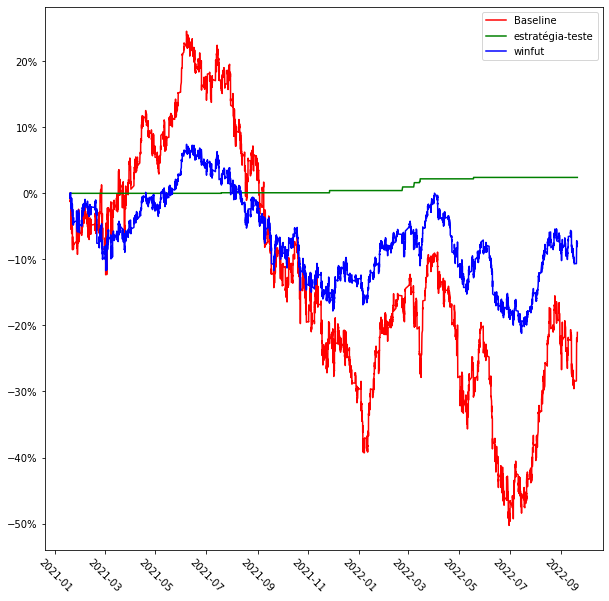

1 finishing ADX,WILLR


In [6]:
lock = threading.Lock()
execute_test([['ADX','WILLR']], [], 0, lock, True)